### Predicting HDB Prices with Multivariate Linear Regression

Having collected the data, wrangled it together, done exploratory data analysis, we will now begin to model the data to predict HDB prices. 

In this notebook, we will be using Multivariate Linear Regression for prediction. This is a 'quick and dirty' model which is fast and reliable, with easy interpretation of model coefficients. 

The final selling price of a HDB isn’t just based on one thing - how big the HDB is, but also factors like the number of bedrooms, the age of the HDB, and maybe even how close it is to the city center. Basically all the data which we have wrangled together. Multivariate linear regression is a fancy way of saying we use all these different bits of information - size, bedrooms, age, location - to make a good guess at the HDB price. Each factor has its own weight in the equation, kind of like ingredients in a recipe, each contributing differently to the final price. 

#### **Objective:** Predict HDB Price (dependent variable) using multiple independent variables (collected data).
- **Equation for Multivariate Linear Regression**
  - Y = β₀ + β₁X₁ + β₂X₂ + ... + βₖXₖ + ε
    - Y: Dependent variable (HDB Price)
    - β₀: Y-intercept
    - β₁, β₂, ... , βₖ: Coefficients for independent variables X₁, X₂, ..., Xₖ (the weights)
    - ε: Error term
- **Assumption**
  - Assumes a linear relationship between dependent and independent variables. Involves multiple independent variables (β).
  - Assumes independence of errors, constant variance of errors (homoscedasticity), and normally distributed errors.
- **Parameters**
  - Coefficients (β) are estimated to minimize the sum of squared residuals. This is the loss function, used to create the line of best fit. 
- **Goodness of Fit**: Measured by metrics like R-squared, Mean Squared Error (MSE), Mean Absolute Error (MAE)
  - In this notebook we will use R2 and MAE.
- **Interpretation**
  - Coefficients indicate the impact/weight of each independent variable on the dependent variable.
- **Variants**
  - Multiple variations exist, including ridge and lasso regression for regularization, which will be explored in other notebooks.
  - Link for Notebook with Ridge regression:
  - Link for Notebook with Lasso regression:



#### Load Libraries

In [31]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Train Test Split
from sklearn.model_selection import train_test_split, cross_validate

# Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Modelling
from sklearn.linear_model import LinearRegression

# Model Evaluation
from sklearn.metrics import mean_absolute_error, r2_score
import scipy.stats as stats

# Saving Model
import pickle

#### Load data into DataFrame and Remove Unwanted Columns

In [2]:
# Make file path variable so that all we need is to change this if we move notebook location
file_path = '../data/processed/final_HDB_for_model.parquet.gzip'

# Read data into csv
df = pd.read_parquet(file_path)

# Check to see if it loaded correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890376 entries, 0 to 890375
Data columns (total 27 columns):
 #   Column                                                                         Non-Null Count   Dtype         
---  ------                                                                         --------------   -----         
 0   town                                                                           890376 non-null  object        
 1   flat_type                                                                      890376 non-null  object        
 2   block                                                                          890376 non-null  object        
 3   street_name                                                                    890376 non-null  object        
 4   storey_range                                                                   890376 non-null  object        
 5   floor_area_sqm                                                          

In [3]:
# Put all columns to be deleted into a list
drop_cols = ['block', 'street_name','address','sold_year_month']

# Drop columns
df = df.drop(columns=drop_cols)

#### Prepare Data for Pipeline and Train Test Split
##### Check for Correlation and Remove Highly Correlated Columns
Removing highly correlated columns makes the model simpler, more accurate, easier to interpret, and more reliable. Why? 
  - **Avoid Redundancy**
    - Highly correlated columns provide similar information. 
    - Keeping both is like hearing the same thing twice. 
  - **Improve Model Accuracy**
    - Linear regression assumes each column (feature) brings unique information. 
    - When columns are too similar (highly correlated), it confuses the model, leading to less accurate predictions.
  - **Prevent Multicollinearity**
    - This is a big word but it just means when columns are highly correlated, they can mess up the way the model understands how important each column is. 
    - This can make it hard to figure out which column really impacts the outcome.
  - **Simpler Model**
    - Removing highly correlated columns simplifies the model. 
    - A simpler model is usually better because it's easier to understand and explain.
  - **Better Generalization**
    - Simplified models with less redundancy often perform better on new, unseen data.
    - This is because they focus on the most relevant information.
  - **Stable Estimates**
    - Highly correlated columns can make the model's estimates (like how much a change in one column will change the outcome) unstable and unreliable. 
    - Removing them helps stabilize these estimates.

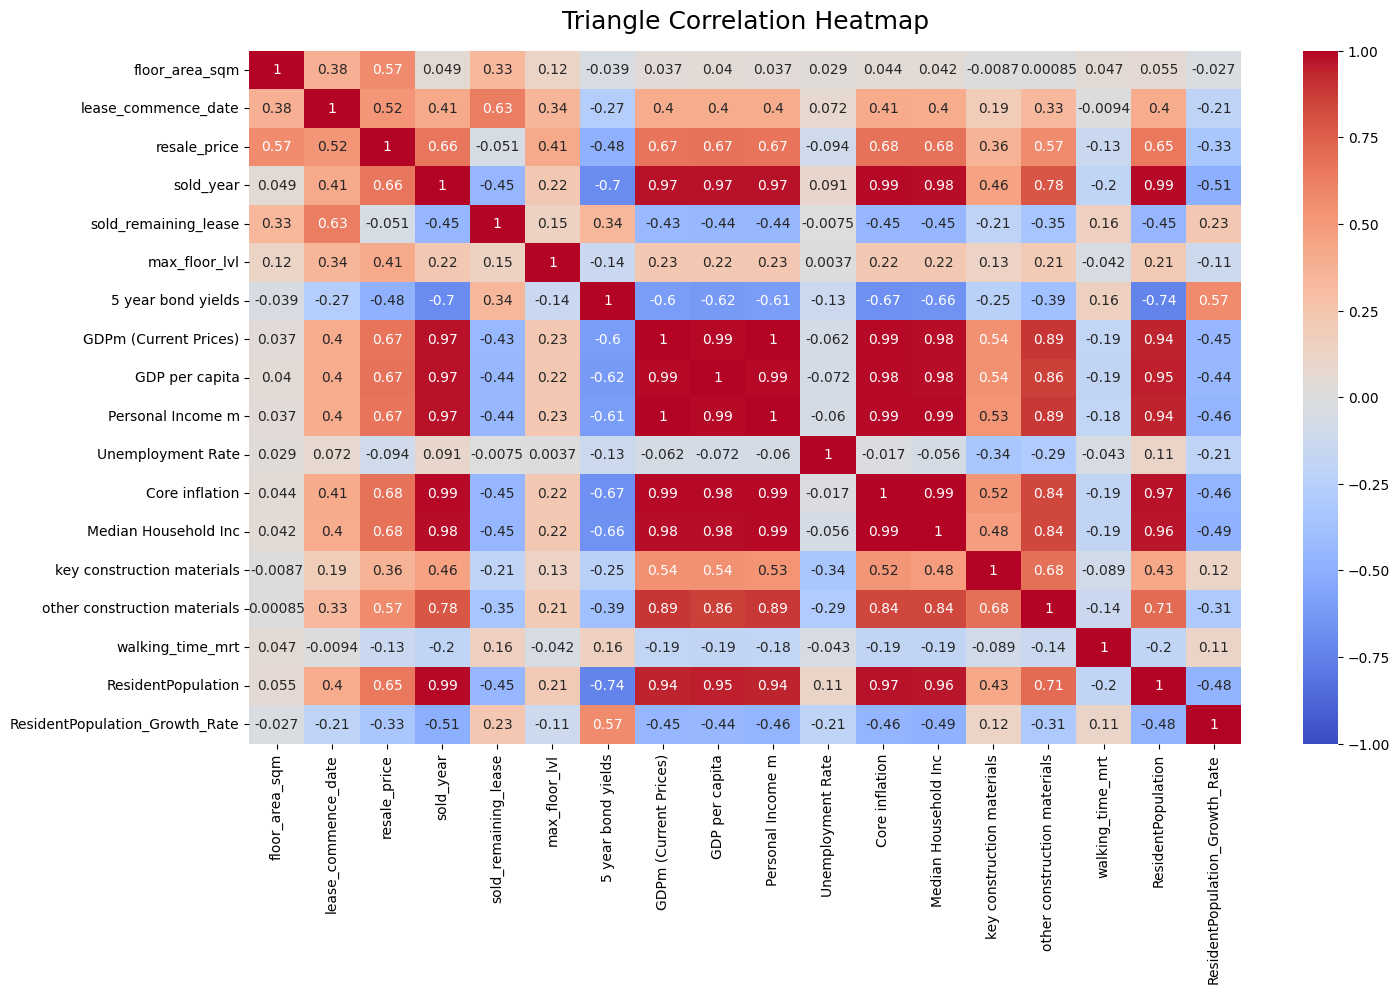

In [4]:
# Rename columns for easier readability
df.columns = df.columns.str.replace('Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials', 'key construction materials')
df.columns = df.columns.str.replace('Clay Construction Materials & Refractory Construction Materials', 'other construction materials')

# Calculate the correlation matrix
correlation_matrix = df.select_dtypes(include=np.number).corr()

# Correlation coefficients
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [5]:
# Threshold for high correlation
threshold = 0.8

# Create empty list to populate
high_correlation_pairs = []

# Double for loop to get value pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            # Get indexes of columns
            col_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            # Append to empty list
            high_correlation_pairs.append(col_pair)

# Print out the pairs of highly correlated columns
for pair in high_correlation_pairs:
    print(pair)

('GDPm (Current Prices)', 'sold_year')
('GDP per capita', 'sold_year')
('GDP per capita', 'GDPm (Current Prices)')
('Personal Income m', 'sold_year')
('Personal Income m', 'GDPm (Current Prices)')
('Personal Income m', 'GDP per capita')
('Core inflation', 'sold_year')
('Core inflation', 'GDPm (Current Prices)')
('Core inflation', 'GDP per capita')
('Core inflation', 'Personal Income m')
('Median Household Inc', 'sold_year')
('Median Household Inc', 'GDPm (Current Prices)')
('Median Household Inc', 'GDP per capita')
('Median Household Inc', 'Personal Income m')
('Median Household Inc', 'Core inflation')
('other construction materials', 'GDPm (Current Prices)')
('other construction materials', 'GDP per capita')
('other construction materials', 'Personal Income m')
('other construction materials', 'Core inflation')
('other construction materials', 'Median Household Inc')
('ResidentPopulation', 'sold_year')
('ResidentPopulation', 'GDPm (Current Prices)')
('ResidentPopulation', 'GDP per cap

Columns to exclude:
- 'GDP per capita'
- 'Personal Income m'
- 'GDPm (Current Prices)'
- 'Median Household Inc'
- 'Core inflation'
- 'ResidentPopulation'
- 'other construction materials'

In [6]:
drop_cols = ['GDP per capita','Personal Income m','GDPm (Current Prices)','Median Household Inc','Core inflation','ResidentPopulation','other construction materials']

df = df.drop(columns=drop_cols)

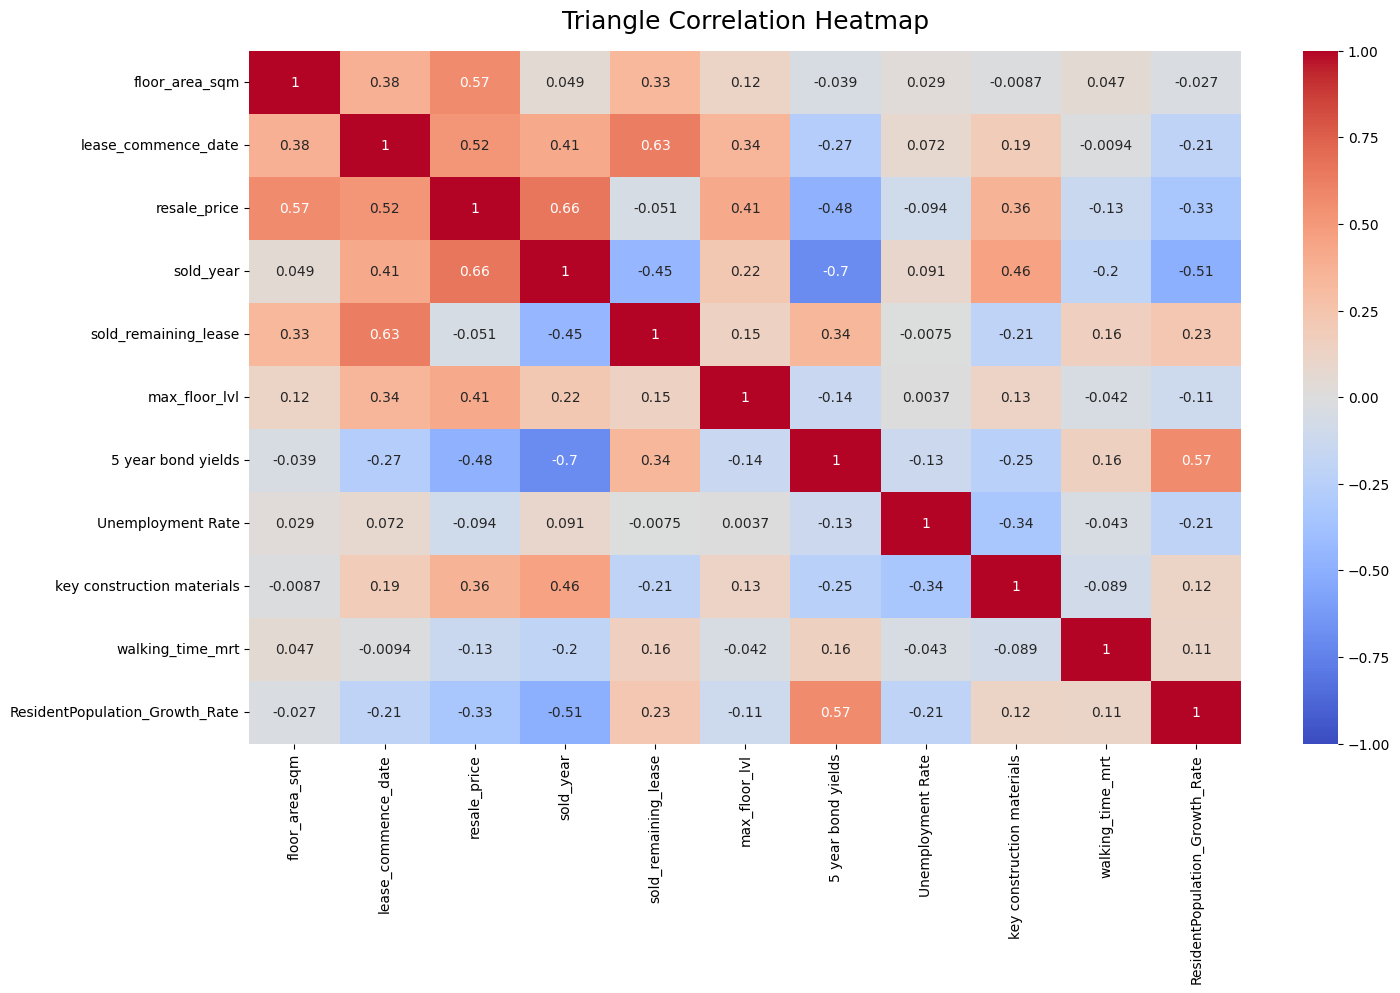

In [7]:
# Calculate the correlation matrix
correlation_matrix = df.select_dtypes(include=np.number).corr()

# Correlation coefficients
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

#### Visualizing Resale Price Against Other Numeric Columns

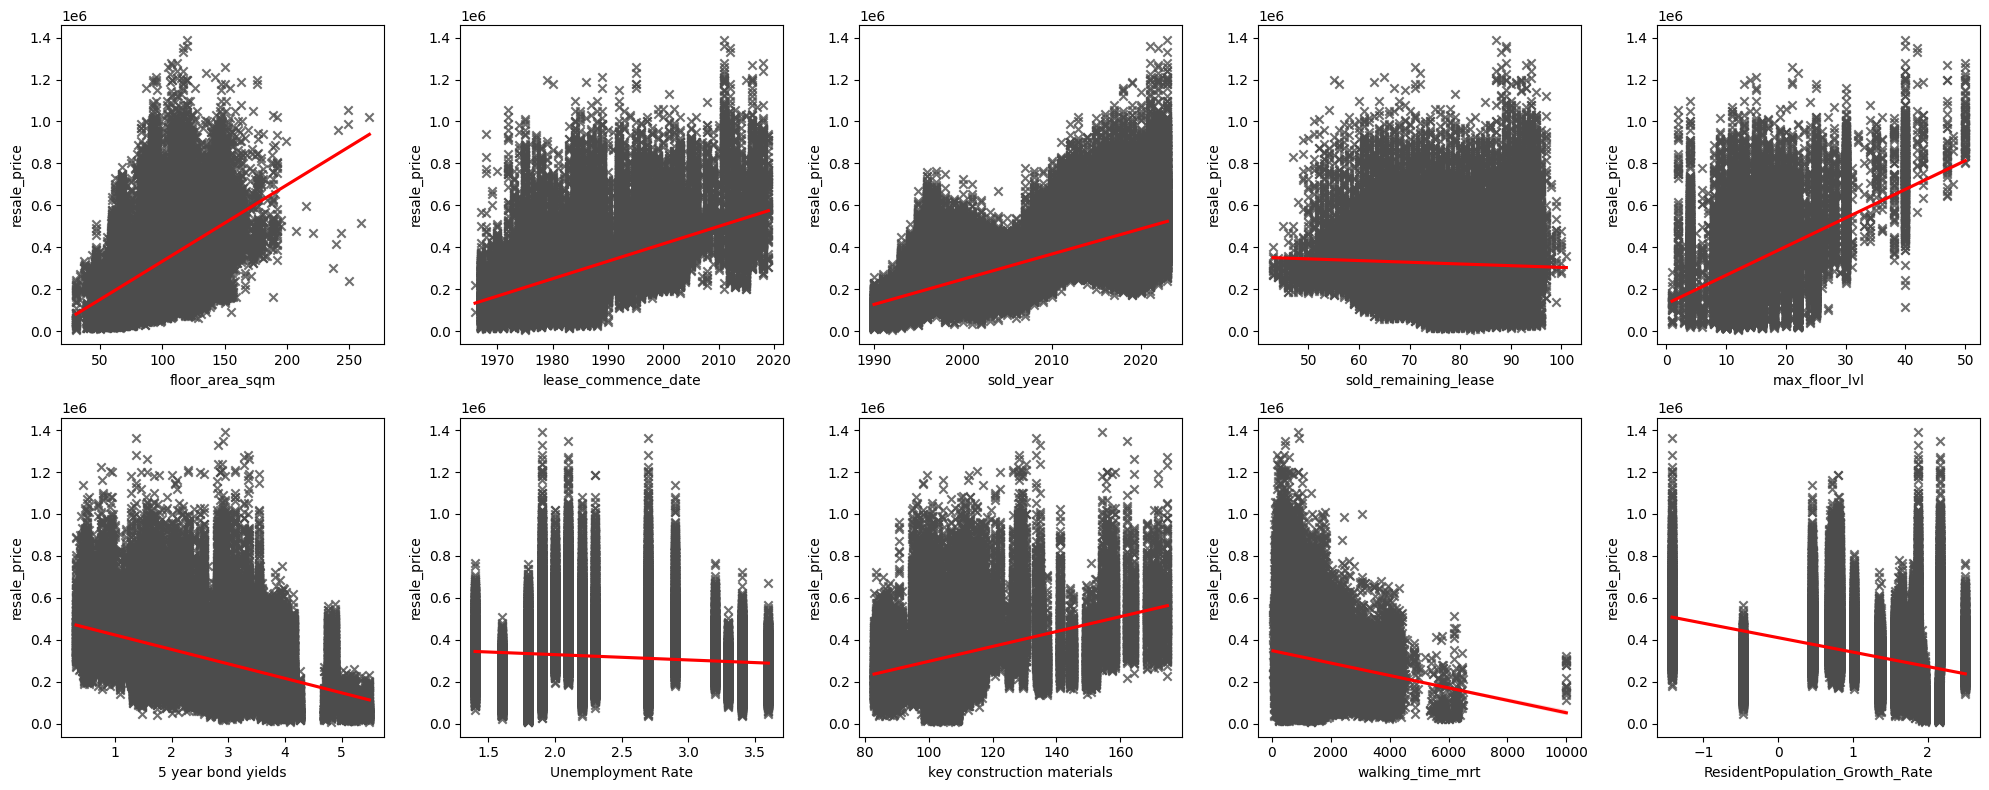

In [37]:
# Get a sample of dataset as full DF takes quite a while
temp = df.sample(100000)

#get list of numeric columns and select column to plot against
column_of_interest = 'resale_price'
other_columns = temp.select_dtypes(include=['int64', 'float64']).columns.drop(column_of_interest)

# Determine the number of rows needed for two plots per row
n_cols = 5
n_rows = ((len(other_columns) + 1) // n_cols )

# Create a figure with subplots
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4 * n_cols, 4 * n_rows))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Loop through other columns and create a scatter plot for each
for i, col in enumerate(other_columns):
    sns.regplot(data=temp, x=col, y=column_of_interest, ax=axs[i],
                ci=99, marker="x", color=".3", line_kws={"color": "r"})

# Adjust layout
plt.tight_layout()
plt.show()

In [10]:
# Create lists of the categorical and numerical columns allowing them to be treated differently
cat_cols = df.select_dtypes(include=['object']).columns

In [8]:
# Create new list of numeric columns, removing resale_price from columns to scale
num_cols_scale = ['floor_area_sqm',
 'lease_commence_date',
 'sold_year',
 'sold_remaining_lease',
 'max_floor_lvl',
 '5 year bond yields',
 'Unemployment Rate',
 'key construction materials',
 'walking_time_mrt',
 'ResidentPopulation_Growth_Rate']

In [11]:
# Select target column
target_col = 'resale_price'

# Ready X and y
X = df.loc[:, ~df.columns.isin([target_col])]
y = df[target_col]

# Split the data, 80-20 split with a random state included for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 54)


#### Creating a Pipeline 
Pipelines are essentially the backbone of efficient and effective data modeling, ensuring a streamlined, consistent, and flexible approach.

 - Streamlining Processes
   - Pipelines allow the combination of various steps like data preprocessing, feature extraction, and model training into one cohesive process.
 - Consistency and Reproducibility
    - They ensure consistent application of preprocessing and modeling steps for reliable results.
 - Ease of Modification
    - Pipelines allow for easy alterations or replacements of individual components without needing to redo the entire process.
 - Avoiding Data Leakage
     - They prevent data leakage during cross-validation by properly managing data preprocessing steps.
 - Simplifying Code
     - Pipelines contribute to more organized and readable code, making the data modeling process cleaner and more manageable.
 - Model Validation and Parameter Tuning
     - They work well with grid search and cross-validation for effective model optimization and validation.
 - Deployment Ready
     - Pipelines simplify the deployment process as they encapsulate all necessary steps in a model's development.
 - Flexibility
     - They are versatile, accommodating various data transformations and modeling techniques.



#### Preprocessing Pipeline

Feature scaling is important for methods that apply a regularization penalty like Ridge or Lasso regression as we are doing here. 

The penalty applied is sum-of-squares in Ridge and sum-of-absolute values in Lasso. If features are on different scales, the regularization does not treat all features equally. Hence, scaling ensures that the regularization term is applied uniformly across all features.

Also, when features are on the same scale, we can more meaningfully compare the magnitude of coefficients to determine which features have more impact on the outcome.

However, in some cases, you might decide not to scale features - if the scale of the features is relevant to the problem (eg: a feature is bounded between 0 and 100 by definition), scaling may not be necessary and might even be misleading.

In [12]:
# Create instances of OneHotEncoder
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Create pipeline of two scalers for numeric data
num_transformer = make_pipeline(RobustScaler(), MinMaxScaler())

# Create a final to apply transformations to subsets of columns
prepoc = make_column_transformer(
    (cat_transformer, cat_cols),
    (num_transformer, num_cols_scale)
)

# View Pipeline
prepoc

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 Index(['town', 'flat_type', 'storey_range', 'flat_model', 'most_closest_mrt'], dtype='object')),
                                ('pipeline',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['floor_area_sqm', 'lease_commence_date',
                                  'sold_year', 'sold_remaining_lease',
                                  'max_floor_lvl', '5 year bond yields',
                                  'Unemployment Rate',
                                  'key construction materials',
                                  'walking_time_mrt',
                                  'ResidentPopulation_Growth_Rate'])])

In [13]:
# Process X & y with pipeline
X_train_processed = prepoc.fit_transform(X_train)
X_test_processed = prepoc.transform(X_test)

In [14]:
# Check to see if it worked
print("Number of columns originally:", X.shape[1])
print("Number of columns after preprocessing:",X_train_processed.shape[1])

Number of columns originally: 15
Number of columns after preprocessing: 183


#### Creating a Base Multivariate Linear Regression Model & Evaluation 

In [15]:
# Instantiate the model
linear_model = LinearRegression()

# Define multiple scoring metrics
scoring = ['r2', 'neg_mean_absolute_error']

# Get the cross validation scores
scores = cross_validate(linear_model, X_train_processed, y_train, cv=5, scoring=scoring, return_train_score=False)

# View scores dictionary
scores

{'fit_time': array([4.66644979, 4.67363286, 4.84093809, 4.46487212, 4.52414775]),
 'score_time': array([0.00469017, 0.0036881 , 0.00302577, 0.00293303, 0.00315404]),
 'test_r2': array([0.87387889, 0.8728603 , 0.87348924, 0.87282136, 0.87295226]),
 'test_neg_mean_absolute_error': array([-44784.24259867, -45079.43951105, -44863.72997666, -44958.68188797,
        -44964.71138684])}

In [16]:
# Get rounded scores stored in variables
train_base_r2_mean = round(scores['test_r2'].mean(), 2)
train_base_mae_mean = round(-(scores['test_neg_mean_absolute_error'].mean()),2)

# Print scores to assess
print("Training r2 score =", train_base_r2_mean)
print("Training Mean Absolute Error =", train_base_mae_mean)

Training r2 score = 0.87
Training Mean Absolute Error = 44930.16


**Training R-squared (R²) Score = 0.87:**
 - R-squared is a statistical measure that represents the proportion of the variance for the dependent variable that's explained by the independent variables in a regression model.
 - In general, a higher R² indicates a better fit of the model to the data.
 - An R² score of 0.87 suggests that 87% of the variability in the HDB price can be explained by the model. 
 - An R² score of 0.87 is typically considered high, indicating that the model explains a large proportion of the variance in the outcome variable.
 - However, it's important to note that a high R² does not necessarily mean the model is good. It doesn't indicate whether the model is appropriate, nor does it imply that the predictions are accurate.

**Training Mean Absolute Error (MAE) = 44930.16:**

 - Mean Absolute Error (MAE) gives an average of the absolute errors between the predicted values and the actual values without considering the direction (i.e., over or under-predicting).
 - It's a common measure of forecast error in regression analysis.
 - A MAE of $44930.16 means that, on average, the predictions of the model are off by $44930.16.
 - The magnitude of the MAE needs to be considered in the context of the scale of the dependent variable - HDB prices. For some datasets, an MAE of 44930.16 might be very small, while for others, it might be considered large. Since HDBs cost on average $500K, having a MAE of ~$50K means the model's output for HDB prices is off by 10% on average. 

In [17]:
# Fitting model on data.
linear_model.fit(X_train_processed, y_train)


LinearRegression()

In [18]:
# Predict y with fitted model
y_pred = linear_model.predict(X_test_processed)

# results
test_base_mae_mean = round(mean_absolute_error(y_test, y_pred),2)
test_base_r2_mean = round(r2_score(y_test, y_pred),2)

print("Testing r2 score =", test_base_r2_mean)
print("Testing Mean Absolute Error =", test_base_mae_mean)

Testing r2 score = 0.87
Testing Mean Absolute Error = 44803.89


**Testing R-squared (R²) Score = 0.87:**
- An R² of 0.87 for the testing set is also high, suggesting that the model has generalized well to new data. 
- It's particularly notable when the testing R² is close to the training R², as it indicates consistency in performance. 

**Testing Mean Absolute Error (MAE) = 44803.89:**
 - The testing MAE being slightly lower than the training MAE (44803.89 vs. 44930.16) is a positive sign. 
 - It suggests that the model is not overfitting and is performing slightly better or at least as well on unseen data compared to the training data.

**Comments on Scores:**

 Overall, these metrics indicate a model that performs consistently on both training and testing data, with a high R² suggesting good explanatory power and a MAE providing insight into the average prediction error. The similarity between training and testing scores is a good sign, indicating that the model has generalized well and is not just fitting to the peculiarities of the training data.

#### Taking a look at the Feature Coefficients

In [19]:
# To Get importance of features in a DF:
# Get feature names
feature_names = prepoc.get_feature_names_out()

# Get coefficients
coefficients = linear_model.coef_

# Create empty Dictionary
feature_coefficients = {}

# For loop to print coefficient and put them into dict
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")
    feature_coefficients[feature] = coef

# Include intercept in the dict
print(f"intercept: {linear_model.intercept_}")
feature_coefficients["intercept"] = linear_model.intercept_

onehotencoder__town_BEDOK: 2750.009072882077
onehotencoder__town_BISHAN: 43707.06541026565
onehotencoder__town_BUKIT BATOK: -102785.7057316937
onehotencoder__town_BUKIT MERAH: -43977.94356762736
onehotencoder__town_BUKIT PANJANG: -42535.71167706007
onehotencoder__town_BUKIT TIMAH: 49648.836724611014
onehotencoder__town_CENTRAL AREA: -32537.741770693283
onehotencoder__town_CHOA CHU KANG: -82686.20260211731
onehotencoder__town_CLEMENTI: -16751.296684846286
onehotencoder__town_GEYLANG: 6641.283800324779
onehotencoder__town_HOUGANG: 55986.40457141878
onehotencoder__town_JURONG EAST: -102868.07853782407
onehotencoder__town_JURONG WEST: -92820.80505810582
onehotencoder__town_KALLANG/WHAMPOA: 7712.269778170594
onehotencoder__town_MARINE PARADE: 116989.63585606145
onehotencoder__town_PASIR RIS: -59603.547688197024
onehotencoder__town_PUNGGOL: 93189.0307114604
onehotencoder__town_QUEENSTOWN: 1077.724974496728
onehotencoder__town_SEMBAWANG: -26392.731666270018
onehotencoder__town_SENGKANG: 69961

In [20]:
# Converting to DataFrame
feature_coefficients_df = pd.DataFrame(list(feature_coefficients.items()), columns=['Feature', 'Coefficient'])
feature_coefficients_df.head()

,Feature,Coefficient
0,onehotencoder__town_BEDOK,2750.009073
1,onehotencoder__town_BISHAN,43707.065410
2,onehotencoder__town_BUKIT BATOK,-102785.705732
3,onehotencoder__town_BUKIT MERAH,-43977.943568
4,onehotencoder__town_BUKIT PANJANG,-42535.711677


In [21]:
# Sorting the DataFrame by the absolute values of the 'Coefficient' column
feature_coefficients_df = feature_coefficients_df.sort_values(by='Coefficient', key=abs, ascending=False)
feature_coefficients_df.head(15)

,Feature,Coefficient
173,pipeline__floor_area_sqm,585792.671162
96,onehotencoder__most_closest_mrt_CHANGI AIRPORT,461241.040076
111,onehotencoder__most_closest_mrt_HAVELOCK,394737.701305
75,onehotencoder__most_closest_mrt_BEAUTY WORLD,362523.882076
86,onehotencoder__most_closest_mrt_BRAS BASAH,355645.168396
123,onehotencoder__most_closest_mrt_LABRADOR PARK,310016.900907
175,pipeline__sold_year,305474.653627
133,onehotencoder__most_closest_mrt_MAXWELL,286368.096505
160,onehotencoder__most_closest_mrt_TELOK BLANGAH,280059.538292
113,onehotencoder__most_closest_mrt_HOLLAND VILLAGE,278112.239882


**Comments**

Model seems to make sense, as floor_area_sqm is the single strongest predictor of price, followed by the closest MRT station to the HDB, the year it was sold, and walking times to the closest MRT. 

#### Plots to Evaluate Model Performance ####
##### Residual Plot

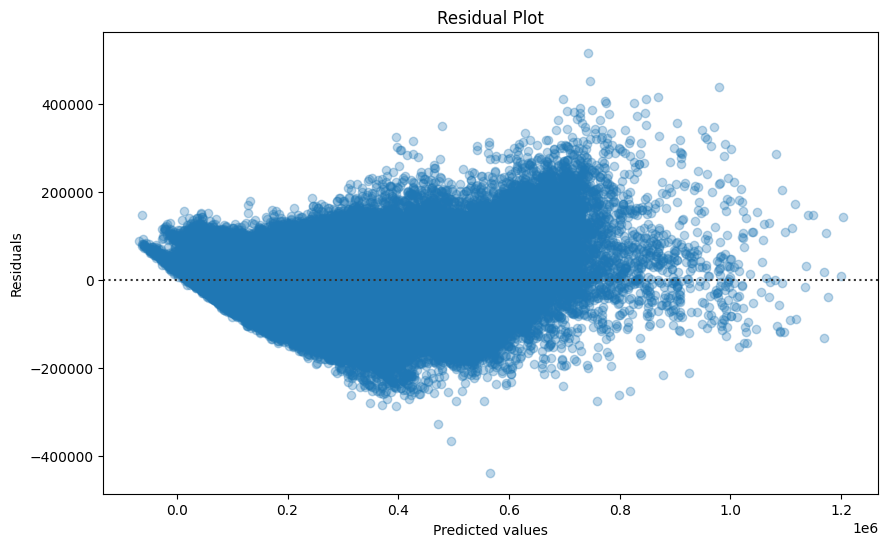

In [22]:
# Get residuals
residuals = y_test - y_pred

# Plot
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, scatter_kws={"alpha": 0.3})
plt.title('Residual Plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

**Comments**

- The residuals are spread out and appear to fan out as the predicted values increase. This pattern suggests heteroscedasticity, where the variability of the residuals is not constant across all levels of the independent variable(s). 
- The model's predictions are less precise at higher values of the predictors.
- The density of points is greater near the lower predicted values and lessens as the predicted value increases. This might indicate that the model has more data points or is more accurate at predicting lower values.
- There don't seem to be many individual points that stray very far from the main cloud of points, which suggests that there are not many extreme outliers in the residuals.

**Conclusion**

- A good fit would show the residuals randomly scattered around the horizontal axis (0 line).
- The fanning out of points indicates that the model may benefit from transformations of the dependent variable or the addition of non-linear terms to better capture the variance associated with the data.
- No clear pattern (like a U-shape or an inverted U-shape) is visible, which is good as such patterns could indicate non-linearity in the data that the model isn't capturing.
- Overall, the residual plot suggests that the model may not have a constant variance of errors, which is an assumption of linear regression models. This could be a sign that the model might need to be revised or improved, possibly with a transformation of variables or a different type of model that accounts for the non-constant variance.

##### Histogram of Residuals

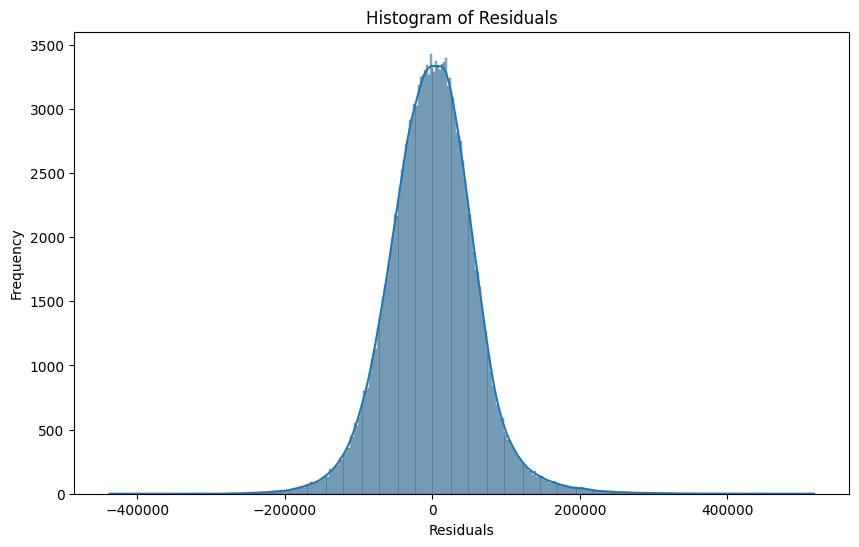

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

**Comments**

- The histogram bars form a shape that is approximately symmetrical around the center (where the residual is zero). This suggests that the residuals are fairly normally distributed, which is an important assumption in linear regression.
- The curve that fits through the tops of the histogram bars appears to be a normal distribution curve, which suggests that the residuals do not deviate significantly from what would be expected under the assumption of normality.

**Conclusion**

- This plot indicates that the model's assumptions of normally distributed errors might be reasonable.
- A normally distributed residuals histogram is a good sign that the linear regression model is appropriate for the data.
- The symmetry around zero suggests that the model does not have a systematic bias either overestimating or underestimating the dependent variable.
- The tails of the distribution do not show signs of heavy skewness or extreme outliers.

##### Q-Q Plot

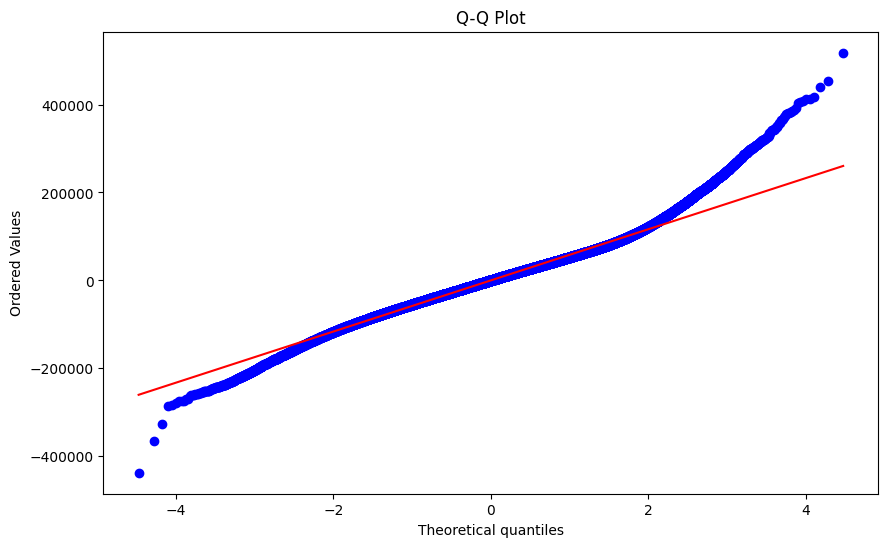

In [24]:
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

**Comments**

- The straight red line represents the place where the points would lie if the data followed a perfect normal distribution.
- Blue dots represent an actual quantile from the dataset plotted against the expected quantile from the normal distribution.
- In the middle portion of the plot (around the 0 of the theoretical quantiles), the points closely follow the reference line, suggesting that the central part of the data is approximately normally distributed.
- The points deviate from the reference line in the tails. In the lower tail (left side of the plot), the data has more extreme values than what would be expected in a normal distribution. The same is true for the upper tail (right side of the plot), where the data points rise above the expected line, indicating heavier tails than a normal distribution.
- The S-shaped curve of the points suggests that the distribution of the dataset has more extreme values compared to a normal distribution. This means that the data may have a higher peak and fatter tails than the normal distribution.

**Conclusion**

- While the central part of the data may resemble a normal distribution, the Q-Q plot indicates that the data exhibit heavier tails, which could impact the assumptions underlying many statistical tests and models that rely on normality. 
- This could be an indication that transformations or alternative modeling techniques might be needed for this dataset.

#### Putting it Together in a Pipeline 

In [26]:
# Read data into csv
df = pd.read_parquet(file_path)

# Put all columns to be deleted into a list
drop_cols = ['block', 'street_name','address','sold_year_month']

# Drop columns
df = df.drop(columns=drop_cols)

num_cols_scale = ['floor_area_sqm',
 'lease_commence_date',
 'sold_year',
 'sold_remaining_lease',
 'max_floor_lvl',
 '5 year bond yields',
 'Unemployment Rate',
 'Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials',
 'walking_time_mrt',
 'ResidentPopulation_Growth_Rate']

# Instantiate the model
model = LinearRegression()

# Apply transformations to subsets of columns
prepoc = make_column_transformer(
    (cat_transformer, cat_cols),
    (num_transformer, num_cols_scale)
)

#create final pipeline
pipe = make_pipeline(prepoc, model)

pipe


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['town', 'flat_type', 'storey_range', 'flat_model', 'most_closest_mrt'], dtype='object')),
                                                 ('pipeline',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['floor_area_sqm',
                                                   'lease_commence_date',
                                                   'sold_year',
                                                   'sold_remaining_lease',
                                                   'max_floor_lvl',
                                                   '5 year bond yields',
                                                   'Unemployment Rate',
                                                   'Lime, Cement, & Fabricated '
                                                   'Construction Materials '
                                                   'Excl Glass & Clay '
                                                   'Materials',
                                                   'walking_time_mrt',
                                                   'ResidentPopulation_Growth_Rate'])])),
                ('linearregression', LinearRegression())])

In [28]:
# Select target column
target_col = 'resale_price'

# Ready X and y
X = df.loc[:, ~df.columns.isin([target_col])]
y = df[target_col]

# Split the data, 80-20 split with a random state included for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 54)

# Fit model
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['town', 'flat_type', 'storey_range', 'flat_model', 'most_closest_mrt'], dtype='object')),
                                                 ('pipeline',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['floor_area_sqm',
                                                   'lease_commence_date',
                                                   'sold_year',
                                                   'sold_remaining_lease',
                                                   'max_floor_lvl',
                                                   '5 year bond yields',
                                                   'Unemployment Rate',
                                                   'Lime, Cement, & Fabricated '
                                                   'Construction Materials '
                                                   'Excl Glass & Clay '
                                                   'Materials',
                                                   'walking_time_mrt',
                                                   'ResidentPopulation_Growth_Rate'])])),
                ('linearregression', LinearRegression())])

In [29]:
# R2 score on training set
r2_baseline_train = pipe.score(X_train, y_train)

# MAE for training
y_pred = pipe.predict(X_train)
mae_baseline_train = mean_absolute_error(y_train, y_pred)

# Print scores to assess
print("Training r2 score =", round(r2_baseline_train, 4))
print("Training MAE score =", round(mae_baseline_train, 2))

Training r2 score = 0.8733
Training MAE score = 44915.62


In [30]:
# R2 score on testing set
r2_baseline_test = pipe.score(X_test, y_test)

# MAE for testing
y_pred = pipe.predict(X_test)
mae_baseline_test = mean_absolute_error(y_test, y_pred)

# Print scores to assess
print("Test r2 score =", round(r2_baseline_test, 4))
print("Test MAE score =", round(mae_baseline_test, 2))

Test r2 score = 0.8735
Test MAE score = 44803.89


In [32]:
#Saving Baseline model
with open('../models/linear_240130.pkl', 'wb') as file:
    pickle.dump(pipe, file)